#Imports

In [0]:
import tensorflow as tf
import keras
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import time
import numpy as np
import os

print("TF: " + tf.__version__)
print("Keras: " + keras.__version__)
local_device_protos = device_lib.list_local_devices()
print("GPU: " + str([x.physical_device_desc for x in local_device_protos]))
!apt-get -qq install -y graphviz && pip install -q pydot
#!apt-get -qq install -y python-opencv
#import cv2 as cv
import pydot
%matplotlib inline 

TF: 1.11.0-rc2
Keras: 2.1.6
GPU: ['', 'device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7']


#Load Dataset

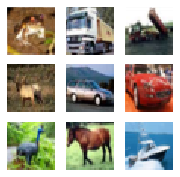

In [0]:
def normalize_all(images):
    out = np.empty(np.shape(images), dtype='float32')
    for i in range(len(images)):
        min_val = np.min(images[i])
        max_val = np.max(images[i])
        out[i] = (images[i] - min_val) / (max_val - min_val)
    return out

#(data_train, labels_train), (data_test, labels_test) = keras.datasets.mnist.load_data()
#(data_train, labels_train), (data_test, labels_test) = keras.datasets.fashion_mnist.load_data()
(data_train, labels_train), (data_test, labels_test) = keras.datasets.cifar10.load_data()
labels_train = keras.utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.to_categorical(labels_test, num_classes=10)
#print(data_train.shape)
#data_train = tf.image.rgb_to_grayscale(data_train)
#data_test = tf.image.rgb_to_grayscale(data_test)

data_train = normalize_all(data_train)
data_test = normalize_all(data_test)

data_train = keras.backend.reshape(data_train, [-1, 32, 32, 3])
data_test = keras.backend.reshape(data_test, [-1, 32, 32, 3])

data_train = tf.Session().run(data_train) # numpy array to tensor
data_test = tf.Session().run(data_test)
plt.figure(figsize=(3,3))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = np.asarray(data_train[i])
    #image = data_train[i]
    plt.imshow(image)
  

# CapsNet

In [0]:
#https://arxiv.org/pdf/1710.09829.pdf
#https://raw.githubusercontent.com/nnUyi/CapsNet/master/a_routing.jpg
#https://raw.githubusercontent.com/naturomics/CapsNet-Tensorflow/master/imgs/capsuleVSneuron.png

class Length(keras.layers.Layer):
  def call(self, inputs, **kwargs):
    return keras.backend.sqrt(keras.backend.sum(keras.backend.square(inputs), -1))

  def compute_output_shape(self, input_shape):
    return input_shape[:-1]

  
def margin_loss(y_true, y_pred):
    loss = y_true * keras.backend.square(keras.backend.maximum(0.0, 0.9 - y_pred)) + 0.5 * (1 - y_true) * keras.backend.square(keras.backend.maximum(0.0, y_pred - 0.1))
    return keras.backend.sum(loss, 1)
  
def squash(inputs):
  norm = keras.backend.sum(keras.backend.square(inputs), -1, keepdims=True)
  s = norm / (1 + norm)
  return s * (inputs / keras.backend.sqrt(norm + 1.0e-10))


def PrimaryCaps(inputs, vector_len=8, num_channels=32, kernel_size=[9,9], strides=[2,2], padding='valid', name=''):
  conv = keras.layers.Conv2D(name=name + '_primary_caps_conv', filters=vector_len*num_channels, kernel_size=kernel_size, strides=strides, padding=padding, activation=keras.activations.relu)(inputs)
  reshape = keras.layers.Reshape(target_shape=[-1, vector_len], name=name + '_primary_caps_reshape')(conv)
  return keras.layers.Lambda(name=name + '_squash', function=squash)(reshape)

#class PrimaryCaps(keras.layers.Layer):
#  def __init__(self, vector_len=8, num_channels=32, kernel_size=[9,9], strides=[2,2], padding='valid'):
#   self.vector_len = vector_len
#   self.num_channels = num_channels
#   self.kernel_size = kernel_size
#   self.strides = strides
#   self.padding = padding
#   super(PrimaryCaps, self).__init__(**kwargs)

#   def build(self, input_shape):
#     h = math.ceil(float(input_shape[1] - self.kernel_size[0] + 1) / float(self.strides[0]))
#     w = math.ceil(float(input_shape[2] - self.kernel_size[1] + 1) / float(self.strides[1]))
#     self.out_shape = tuple([None, w*h*self.num_channels, self.vector_len])
#     self.conv = keras.layers.Conv2D(name='primary_caps_conv', filters=self.vector_len*self.num_channels, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, activation=keras.activations.relu)
#     self.reshape = keras.layers.Reshape(target_shape=[-1, self.vector_len], name='primary_caps_reshape')
#     super(PrimaryCaps, self).build(input_shape)

#   def compute_output_shape(self, input_shape):
#     return self.out_shape

#   def call(self, inputs):
#     _conv = self.conv(inputs)
#     _reshape = self.reshape(_conv)
#     return keras.layers.Lambda(squash)(_reshape)


class DigitCaps(keras.layers.Layer):
  def __init__(self, num_caps, vector_len=16, routings=3, kernel_initializer=keras.initializers.glorot_uniform(seed=None), **kwargs): 
    self.num_caps = num_caps
    self.vector_len = vector_len
    self.routings = routings
    self.kernel_initializer = keras.initializers.get(kernel_initializer)
    super(DigitCaps, self).__init__(**kwargs)

  def build(self, input_shape):
    self.num_caps_in = input_shape[1]
    self.vector_len_in = input_shape[2]
    self.w = self.add_weight(shape=[self.num_caps, self.num_caps_in, self.vector_len, self.vector_len_in], initializer=self.kernel_initializer, name='w')
    super(DigitCaps, self).build(input_shape)

  def compute_output_shape(self, input_shape):
    return tuple([None, self.num_caps, self.vector_len])

  def call(self,inputs):
    inputs_expand = keras.backend.expand_dims(inputs, 1)
    inputs_tiled = keras.backend.tile(inputs_expand, [1, self.num_caps, 1, 1])
    u_hat = keras.backend.map_fn(lambda x: keras.backend.batch_dot(x, self.w, [2, 3]), elems=inputs_tiled) # u_hat = inputs * w
    b = keras.backend.zeros(shape=[keras.backend.shape(u_hat)[0], self.num_caps, self.num_caps_in]) # b = 0
    for i in range(self.routings):
      c = keras.activations.softmax(b, axis=1)
      s = keras.backend.batch_dot(c, u_hat, [2, 2]) # s = c * u_hat
      v = squash(s)
      if i < self.routings - 1:
        b += keras.backend.batch_dot(v, u_hat, [2, 3]) # b += u_hat * v
    return v

  
start = time.time()
print("Started at: " + str(time.asctime(time.gmtime(start))) + " GMT")

num_class = 10
routings = 3
input_shape = (data_train.shape[1], data_train.shape[2], data_train.shape[3])
input = keras.layers.Input(name='input', shape=input_shape)

conv = keras.layers.Conv2D(name='conv', filters=256, kernel_size=[9,9], strides=[1,1], padding='same', activation=keras.activations.relu)(input)

prim_caps = PrimaryCaps(inputs=conv, vector_len=8, num_channels=64, kernel_size=[9,9], strides=[2,2], padding='valid', name='prim_c')

digit_caps = DigitCaps(name='digit_caps', num_caps=num_class, vector_len=16, routings=routings)(prim_caps)

out_caps = Length(name='output')(digit_caps)
model = keras.Model(input, out_caps)

batch_size = 128
epochs = 50
loss = margin_loss # 'categorical_crossentropy'
#optimizer = keras.optimizers.RMSprop()
#optimizer = keras.optimizers.Adadelta()
#optimizer = keras.optimizers.Adamax()
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
print(model.summary())
keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
from google.colab import files
files.download( "model.png" )
#img = cv.imread("model.png")
#plt.imshow(img)
#plt.show()
try:
  model.fit(data_train, labels_train, validation_split=0.02, batch_size=batch_size, epochs=epochs)
except KeyboardInterrupt:
  print("")
  print("test")
  test_loss, test_acc = model.evaluate(data_test, labels_test)
else:  
  print("")
  print("test")
  test_loss, test_acc = model.evaluate(data_test, labels_test)
#print(model.summary())
print('Test accuracy:', test_acc*100, "%")
print('Test loss:', test_loss)

end = time.time()
print("Execution time: " + str(end-start) + " seconds")

Started at: Sat Sep 29 19:03:59 2018 GMT
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv (Conv2D)                   (None, 32, 32, 256)  62464       input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 128)  819328      conv[0][0]                       
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 32, 32, 131)  0           conv1[0][0]                      
                                                                 inp

KeyboardInterrupt: ignored

## Results with default config 

###MNIST:

  optimizer = keras.optimizers.Adam()

  batch_size = 100

  Epoch 20/20
  60000/60000 [==============================] - 721s 12ms/step - loss: 0.0264 - acc: 0.9969

  10000/10000 [==============================] - 41s 4ms/step
  _________________________________________________________________
  Layer (type) -------------------------------------------- Output Shape --------------- Param #   

  =================================================================

  input_1 (InputLayer) ------------------------------- (None, 28, 28, 1) ----------- 0
  _________________________________________________________________
  conv_1 (Conv2D) ------------------------------------ (None, 20, 20, 256) ------ 20992
  _________________________________________________________________
  primary_caps_conv (Conv2D) ---------------- (None, 6, 6, 256) ---------- 5308672
  _________________________________________________________________
  primary_caps_reshape (Reshape) ---------- (None, 1152, 8) ----------- 0
  _________________________________________________________________
  primary_caps_squash (Lambda) ----------- (None, 1152, 8) ------------ 0
  _________________________________________________________________
  digit_caps (CapsuleLayer) --------------------- (None, 10, 16) -------------- 1474560
  _________________________________________________________________
  capsnet__ (Length) -------------------------------- (None, 10) -------------------- 0

  =================================================================

  Total params: 6,804,224

  Trainable params: 6,804,224

  Non-trainable params: 0

  _________________________________________________________________


  Test accuracy: 98.92 %




###MNIST_FASHION:

  optimizer = keras.optimizers.Adam()

  batch_size = 100

  Epoch 10/10
  60000/60000 [==============================] - 662s 11ms/step - loss: 0.4113 - acc: 0.8710

  10000/10000 [==============================] - 46s 5ms/step
  _________________________________________________________________
  Layer (type) -------------------------------------------- Output Shape --------------- Param # 

  =================================================================
  
  input_1 (InputLayer) ------------------------------- (None, 28, 28, 1) ----------- 0
  _________________________________________________________________
  conv_1 (Conv2D) ------------------------------------ (None, 20, 20, 256) ------ 20992
  _________________________________________________________________
  primary_caps_conv (Conv2D) ---------------- (None, 6, 6, 256) ---------- 5308672
  _________________________________________________________________
  primary_caps_reshape (Reshape) ---------- (None, 1152, 8) ----------- 0
  _________________________________________________________________
  primary_caps_squash (Lambda) ----------- (None, 1152, 8) ------------- 0
  _________________________________________________________________
  digit_caps (CapsuleLayer) --------------------- (None, 10, 16) -------------- 1474560
  _________________________________________________________________
  capsnet__ (Length) -------------------------------- (None, 10) -------------------- 0

  =================================================================

  Total params: 6,804,224

  Trainable params: 6,804,224

  Non-trainable params: 0
  _________________________________________________________________

  Test accuracy: 86.00999999999999 %